# Medical Insurance Project
### Introduction
#### This project uses a medical insurance dataset that records the cost of insurance along with several personal and lifestyle factors: age, sex, BMI, number of children, smoking status, and region. The aim is to investigate how these factors are associated with insurance charges and to identify which variables have the strongest influence.
### Background
#### Although the UK operates under the NHS and most people do not pay directly for medical insurance, this dataset offers an opportunity to explore how health, lifestyle, and demographic factors influence medical costs in a system where insurance is a major factor. By analysing these relationships, I can apply statistical and data science methods to uncover meaningful associations, while also developing transferable analytical skills.
### Research Questions
#### Q1. What does the distribution of charges look like?
#### Q2. How many charges vary across regions? Is healthcare more expensive in one region vs others?
#### Q3. Do smokers pay more than non-smokers?
#### Q4. Is there a difference in charges between males and females?
#### Q5. How does BMI relate to medical charges?
#### Q6. Do age and number of children affect charges?
#### Q7. Which factor (age, BMI, children) has the strongest effect on charges?
#### Q8: Is there an association between number of children and smoking status?
#### Q9: Are smokers more likely to fall into the 'High charges' category compared to non-smokers?

## Check and clean the data

In [236]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, chi2_contingency, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

df = pd.read_csv('insurance.csv')
print(df.head())
print()
print(df.info()) # display info about dataset
print()
print(df.describe()) # display stats about data
print()
print(f"Sex options: {df.sex.unique()}")
print(f"Smoker options: {df.smoker.unique()}")
print(f"Region options: {df.smoker.unique()}")
print()

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

               age          bmi     children       charges
count  1338.000000  1338.00000

In [222]:
# Categorise bmi
bins = [0, 18.5, 25, 30, float("inf")]
labels = ["Underweight", "Normal weight", "Overweight", "Obese"]
df['bmi_category'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)
df['bmi_category'] = pd.Categorical(
    df['bmi_category'],
    categories = ["Underweight", "Normal weight", "Overweight", "Obese"],
    ordered = True
)

# Categorise charges
lowest_charge = df['charges'].min()
low_charge = df['charges'].quantile(0.33)
medium_charge = df['charges'].quantile(0.66)
high_charge = df['charges'].max()
bins = [lowest_charge, low_charge, medium_charge, high_charge]
labels = ["Low", "Medium", "High"]
df['charges_category'] = pd.cut(df['charges'], bins=bins, labels=labels, right=False)
df['charges_category'] = pd.Categorical(
    df['charges_category'],
    categories = ["Low", "Medium", "High"],
    ordered = True
)

print(df.head())

   age     sex     bmi  children smoker     region      charges  \
0   19  female  27.900         0    yes  southwest  16884.92400   
1   18    male  33.770         1     no  southeast   1725.55230   
2   28    male  33.000         3     no  southeast   4449.46200   
3   33    male  22.705         0     no  northwest  21984.47061   
4   32    male  28.880         0     no  northwest   3866.85520   

    bmi_category charges_category  
0     Overweight             High  
1          Obese              Low  
2          Obese              Low  
3  Normal weight             High  
4     Overweight              Low  


In [223]:
# 0 bmi is not possible for a living person
check_bmi = len(df.bmi[df.bmi == 0])
print(f"Check invalid bmi: {check_bmi}")

# This is unlikely but possible so I'm not going to remove the duplicate
print(f"Duplicated rows: {df.duplicated().sum()}")
print(df[df.duplicated(keep=False)])

Check invalid bmi: 0
Duplicated rows: 1
     age   sex    bmi  children smoker     region    charges bmi_category  \
195   19  male  30.59         0     no  northwest  1639.5631        Obese   
581   19  male  30.59         0     no  northwest  1639.5631        Obese   

    charges_category  
195              Low  
581              Low  


In [237]:
# dataframe for modelling
modelling_data = pd.get_dummies(df, drop_first=True)
print(modelling_data.head())

   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  


## Q1. What does the distribution of charges look like?

Charges mean: 13270.422265141257
Charges median: 9382.033
Charges mean - median: 3888.389265141257


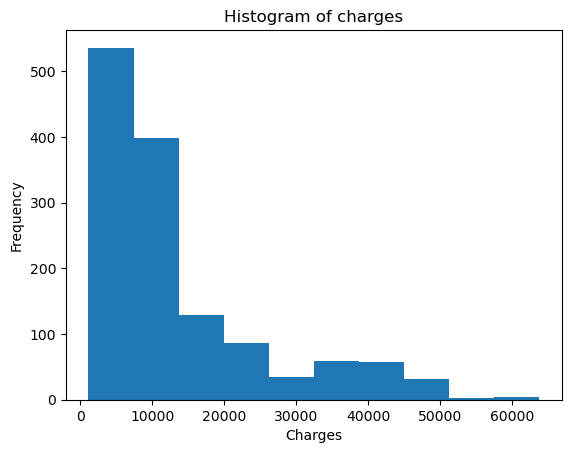

<Figure size 640x480 with 0 Axes>

In [225]:
# Since mean > median, histogram will be right-skewed
charges_mean = df['charges'].mean()
charges_median = df['charges'].median()
charges_diff = charges_mean - charges_median
print(f"Charges mean: {charges_mean}")
print(f"Charges median: {charges_median}")
print(f"Charges mean - median: {charges_diff}")

# Lets check
plt.hist(df['charges'], bins=10)
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Histogram of charges')
plt.show()
plt.clf()
# Histogram is right-skewed

### Conclusion
#### The right-skewed distribution, with the mean greater than the median, shows that most people pay relatively low insurance charges, while a small number of very high outliers (above 50,000) drive up the average.

## Q2. How many charges vary across regions? Is healthcare more expensive in one region vs others?

['southwest' 'southeast' 'northwest' 'northeast']
Charges (mean - median) by region
northeast    3348.732491
northwest    3451.779624
southeast    5441.279488
southwest    3548.344377
Name: charges, dtype: float64


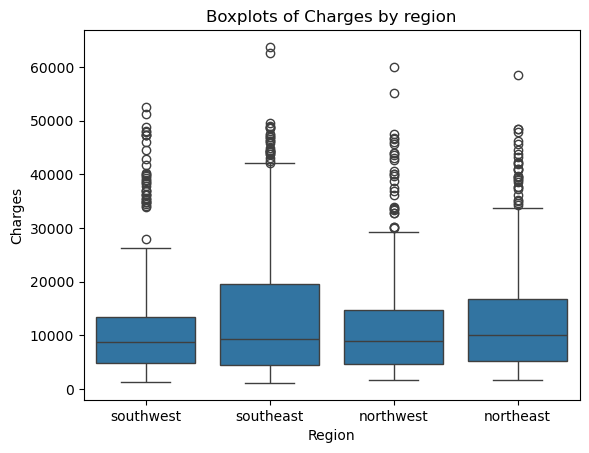

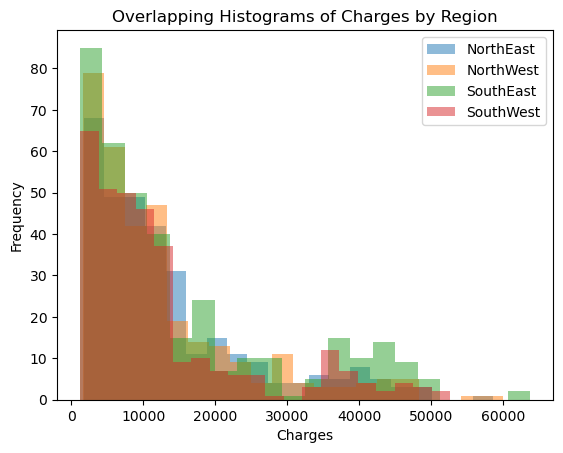

<Figure size 640x480 with 0 Axes>

In [226]:
regions = df['region'].unique()
print(regions)

# mean and median differences
region_charges_mean = df.groupby('region')['charges'].mean()
region_charges_median = df.groupby('region')['charges'].median()
region_charges_diff = region_charges_mean - region_charges_median
print(F"Charges (mean - median) by {region_charges_diff}")

# side-by-side boxplots
sns.boxplot(x = 'region', y = 'charges', data = df)
plt.xlabel('Region')
plt.ylabel('Charges')
plt.title('Boxplots of Charges by region')
plt.show()
plt.clf()

# overlapping histograms
plt.hist(df[df['region'] == 'northeast']['charges'], bins = 20, alpha = 0.5, label = 'NorthEast')
plt.hist(df[df['region'] == 'northwest']['charges'], bins = 20, alpha = 0.5, label = 'NorthWest') 
plt.hist(df[df['region'] == 'southeast']['charges'], bins = 20, alpha = 0.5, label = 'SouthEast')
plt.hist(df[df['region'] == 'southwest']['charges'], bins = 20, alpha = 0.5, label = 'SouthWest') 
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Overlapping Histograms of Charges by Region')
plt.legend()
plt.show()
plt.clf()

### Conclusion
#### The side-by-side boxplots and overlapping histogram indicate that insurance charges are fairly similar across regions. However, there is a slight ordering from least to most expensive — Southwest, Northwest, Northeast, and Southeast — with the more expensive regions showing more values on the higher end of the distribution.

## Q3. Do smokers pay more than non-smokers?

Charges (mean - median) based on smoker
no     1088.862998
yes   -2406.116618
Name: charges, dtype: float64


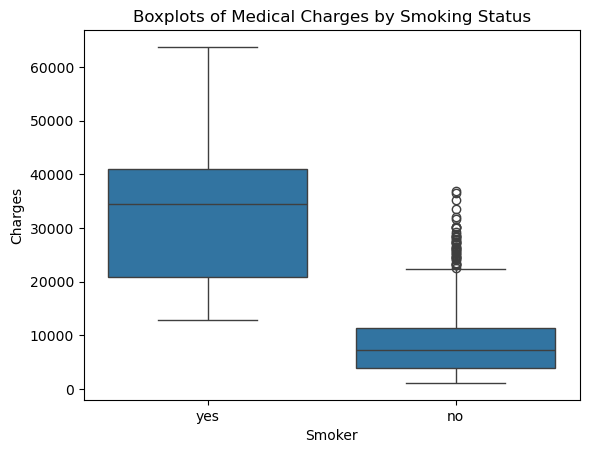

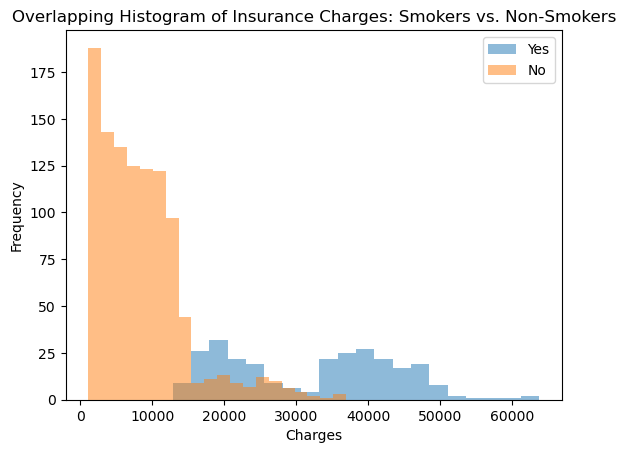

<Figure size 640x480 with 0 Axes>

In [227]:
# mean and median differences
smoker_charges_mean = df.groupby('smoker')['charges'].mean()
smoker_charges_median = df.groupby('smoker')['charges'].median()
smoker_charges_diff = smoker_charges_mean - smoker_charges_median
print(f"Charges (mean - median) based on {smoker_charges_diff}")

# side-by-side boxplots
sns.boxplot(x = 'smoker', y = 'charges', data = df)
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.title('Boxplots of Medical Charges by Smoking Status')
plt.show()
plt.clf()

# overlapping histograms
plt.hist(df[df['smoker'] == 'yes']['charges'], bins = 20, alpha = 0.5, label = 'Yes')
plt.hist(df[df['smoker'] == 'no']['charges'], bins = 20, alpha = 0.5, label = 'No') 
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Overlapping Histogram of Insurance Charges: Smokers vs. Non-Smokers')
plt.legend()
plt.show()
plt.clf()

### Conclusion
#### Both the boxplots and histogram clearly demonstrate that insurance charges are substantially higher for smokers than for non-smokers. Notably, the minimum charge for smokers exceeds the upper quartile charge for non-smokers, highlighting a strong difference between the two groups.

## Q4. Is there a difference in charges between males and females?

Charges (mean - median) based on sex
female    3156.616344
male      4587.135428
Name: charges, dtype: float64


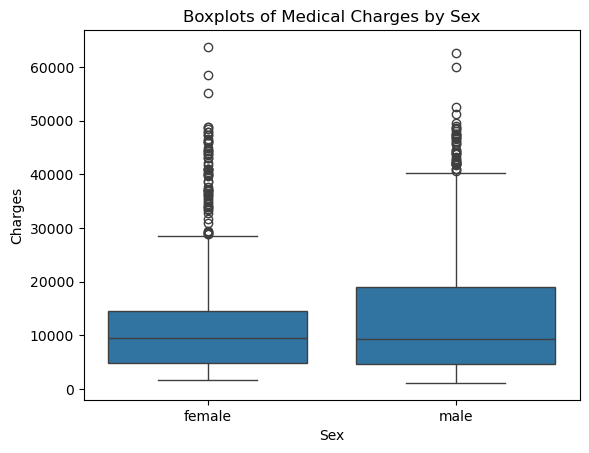

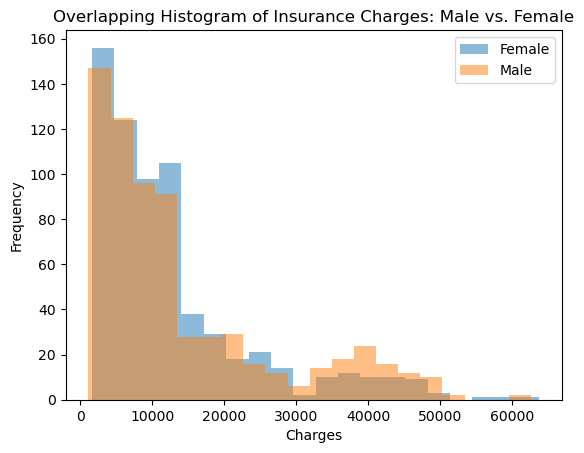

<Figure size 640x480 with 0 Axes>

In [228]:
# mean and median differences
sex_charges_mean = df.groupby('sex')['charges'].mean()
sex_charges_median = df.groupby('sex')['charges'].median()
sex_charges_diff = sex_charges_mean - sex_charges_median
print(f"Charges (mean - median) based on {sex_charges_diff}")

# side-by-side boxplots
sns.boxplot(x = 'sex', y = 'charges', data = df)
plt.xlabel('Sex')
plt.ylabel('Charges')
plt.title('Boxplots of Medical Charges by Sex')
plt.show()
plt.clf()

# overlapping histograms
plt.hist(df[df['sex'] == 'female']['charges'], bins = 20, alpha = 0.5, label = 'Female') 
plt.hist(df[df['sex'] == 'male']['charges'], bins = 20, alpha = 0.5, label = 'Male')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Overlapping Histogram of Insurance Charges: Male vs. Female')
plt.legend()
plt.show()
plt.clf()

### Conclusion
#### The boxplots and mean/median comparisons suggest that men have slightly higher charges than women, but the difference is small. This does not provide strong evidence of gender bias and may be explained by other factors.

## Q5. How does BMI relate to medical charges?

Covariance of 14647 shows that as bmi increases so does charge.
Correlation of 0.198 shows a weak positive relationship.



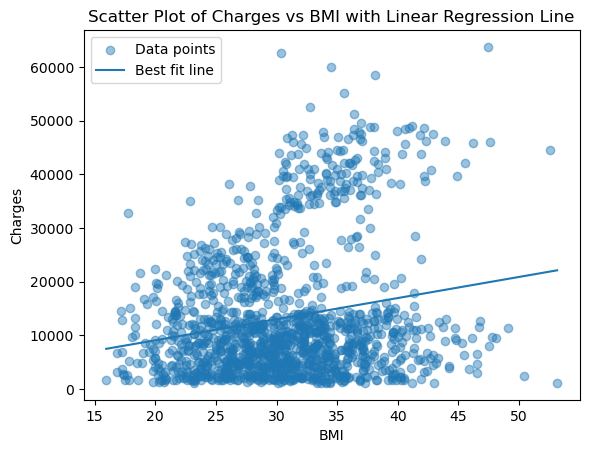

<Figure size 640x480 with 0 Axes>

In [229]:
# bmi
# Covariance
cov_bmi_charge = round(np.cov(df.bmi, df.charges)[0][1])
print(f"Covariance of {cov_bmi_charge} shows that as bmi increases so does charge.")

# Correlation
corr_bmi_charge, p = pearsonr(df.bmi, df.charges)
print(f"Correlation of {round(corr_bmi_charge, 3)} shows a weak positive relationship.")
print()

# Regression line
def linearRegressionEq(x_value, y_value):
    x = df[[x_value]]
    y = df[[y_value]]
    
    model = LinearRegression()
    model.fit(x, y)
    m = model.coef_[0][0]
    b = model.intercept_[0]

    m_scaled = m * (x.std().iloc[0] / y.std().iloc[0])
    x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    x_vals = pd.DataFrame(x_vals, columns = [x_value])
    y_vals = model.predict(x_vals)
    return m, b, m_scaled, x, y, x_vals, y_vals

# Scatter plot
m, b, m_scaled, x, y, x_vals, y_vals = linearRegressionEq('bmi', 'charges')
plt.scatter(x, y, alpha = 0.45, label = "Data points")
plt.plot(x_vals, y_vals, label = "Best fit line")
plt.xlabel('BMI')
plt.ylabel("Charges")
plt.title("Scatter Plot of Charges vs BMI with Linear Regression Line")
plt.legend()
plt.show()
plt.clf()

Charges (mean - median) based on bmi_category
Underweight      2092.938110
Normal weight    1805.514309
Overweight       2328.131891
Obese            5588.275469
Name: charges, dtype: float64


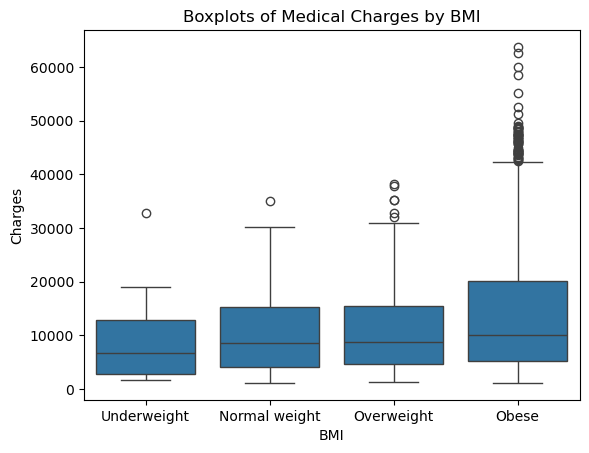

<Figure size 640x480 with 0 Axes>

In [230]:
# bmi_category
# mean and median differences
bmi_charges_mean = df.groupby('bmi_category', observed=True)['charges'].mean()
bmi_charges_median = df.groupby('bmi_category', observed=True)['charges'].median()
bmi_charges_diff = bmi_charges_mean - bmi_charges_median
print(f"Charges (mean - median) based on {bmi_charges_diff}")

# side-by-side boxplots
sns.boxplot(x = 'bmi_category', y = 'charges', data = df)
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title('Boxplots of Medical Charges by BMI')
plt.show()
plt.clf()

### Conclusion
#### There is a weak but positive correlation between BMI and insurance charges. Higher BMI categories tend to have higher median charges, and the obese group shows the most high-cost outliers, reflecting the increased health risks and expenses associated with obesity.

## Q6. Do age and number of children affect charges?

Covariance of 50875 shows that as age increases so does charge.
Correlation of 0.299 shows a weak positive relationship.


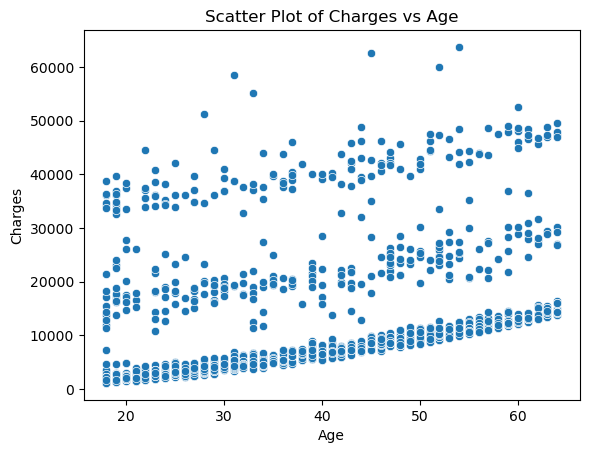

<Figure size 640x480 with 0 Axes>

In [231]:
# Age
# Covariance
cov_age_charge = round(np.cov(df.age, df.charges)[0][1])
print(f"Covariance of {cov_age_charge} shows that as age increases so does charge.")

# Correlation
corr_age_charge, p = pearsonr(df.age, df.charges)
print(f"Correlation of {round(corr_age_charge, 3)} shows a weak positive relationship.")

# Scatter plot
sns.scatterplot(x = 'age', y = 'charges', data = df)
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Scatter Plot of Charges vs Age')
plt.show()
plt.clf()

Covariance of 993 shows that as bmi increases so does charge.
Correlation of 0.068 shows a very weak positive relationship.


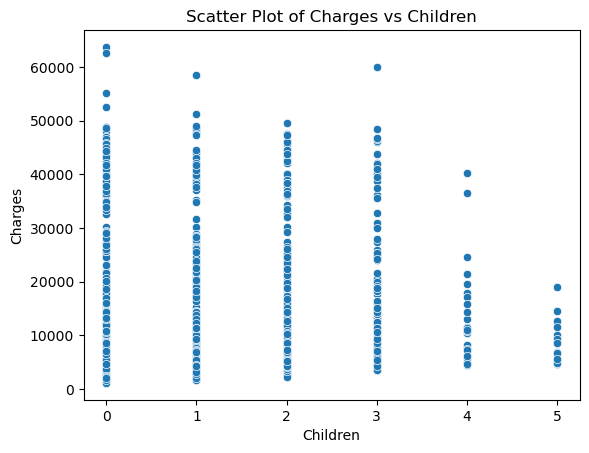

<Figure size 640x480 with 0 Axes>

In [232]:
# Number of Children
# Covariance
cov_children_charge = round(np.cov(df.children, df.charges)[0][1])
print(f"Covariance of {cov_children_charge} shows that as bmi increases so does charge.")

# Correlation
corr_children_charge, p = pearsonr(df.children, df.charges)
print(f"Correlation of {round(corr_children_charge, 3)} shows a very weak positive relationship.")

# Scatter plot
sns.scatterplot(x = 'children', y = 'charges', data = df)
plt.xlabel('Children')
plt.ylabel('Charges')
plt.title('Scatter Plot of Charges vs Children')
plt.show()
plt.clf()

### Conclusion
#### There is a positive association between age and insurance charges, with older individuals generally incurring higher costs. In contrast, the number of children shows only a very weak positive correlation with charges, which is negligible and likely influenced by outliers.

## Q7. Which factor (age, BMI, children) has the strongest effect on charges?

Charges = 1192.94 + 393.87 * bmi
Gradient scaled value: 0.198


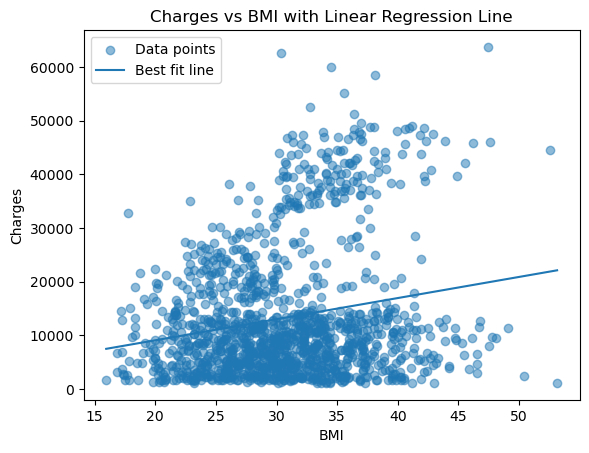


Charges = 3165.89 + 257.72 * age
Gradient scaled value: 0.299


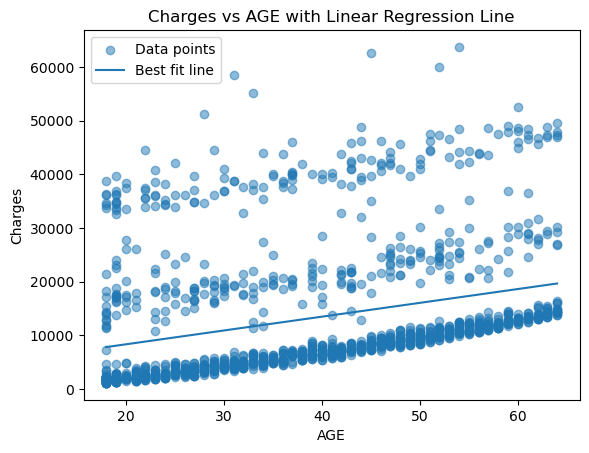


Charges = 12522.50 + 683.09 * children
Gradient scaled value: 0.068


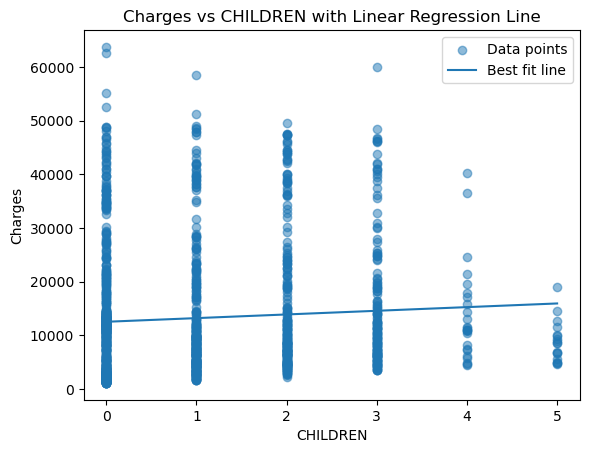


The biggest quantative factor is age.
With the largest gradient scaled value of: 0.299


<Figure size 640x480 with 0 Axes>

In [238]:
all_m_scaled = {}
quantative_columns = ["bmi", "age", "children"]

# retrieves all relevant data for the above columns
for col in quantative_columns:
    m, b, m_scaled, x, y, x_vals, y_vals = linearRegressionEq(col, 'charges')
    all_m_scaled[col] = m_scaled
    print(f"Charges = {b:.2f} + {m:.2f} * {col}")
    print(f"Gradient scaled value: {m_scaled:.3f}")
    plt.scatter(x, y, alpha = 0.5, label = "Data points")
    plt.plot(x_vals, y_vals, label = "Best fit line")
    plt.xlabel(col.upper())
    plt.ylabel("Charges")
    plt.title(f"Charges vs {col.upper()} with Linear Regression Line")
    plt.legend()
    plt.show()
    plt.clf()
    print()

max_m_factor = max(all_m_scaled, key=all_m_scaled.get) # get the largest gradient scal factor
print(f"The biggest quantative factor is {max_m_factor}.")
print(f"With the largest gradient scaled value of: {all_m_scaled[max_m_factor]:.3f}")

### Conclusion
#### Age is the strongest quantitative predictor of insurance charges, with a scaled gradient value of 0.299. This indicates that age has a greater impact on charges than either BMI or the number of children.

## Q8: Is there an association between number of children and smoking status?

Charges (mean - median) based on smoker
no     0.090226
yes    0.113139
Name: children, dtype: float64


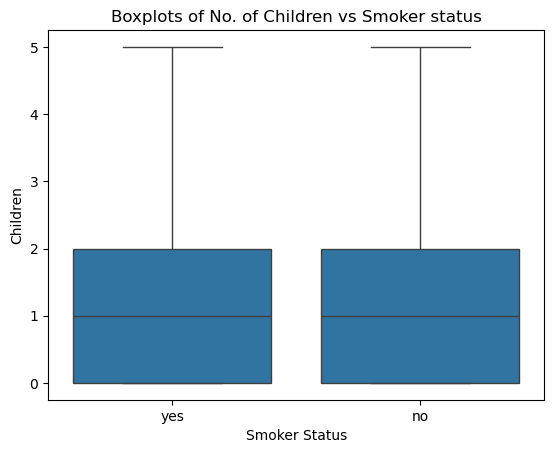

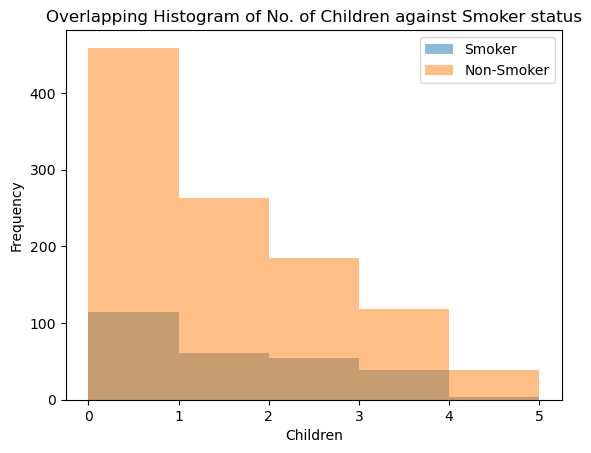

<Figure size 640x480 with 0 Axes>

In [234]:
# mean and median differences
children_smoker_mean = df.groupby('smoker')['children'].mean()
children_smoker_median = df.groupby('smoker')['children'].median()
children_smoker_diff = children_smoker_mean - children_smoker_median
print(f"Charges (mean - median) based on {children_smoker_diff}")

# side-by-side boxplots
sns.boxplot(x = 'smoker', y = 'children', data = df)
plt.xlabel('Smoker Status')
plt.ylabel('Children')
plt.title('Boxplots of No. of Children vs Smoker status')
plt.show()
plt.clf()

# overlapping histograms
plt.hist(df[df['smoker'] == 'yes']['children'], bins = 5, alpha = 0.5, label = 'Smoker') 
plt.hist(df[df['smoker'] == 'no']['children'], bins = 5, alpha = 0.5, label = 'Non-Smoker')
plt.xlabel('Children')
plt.ylabel('Frequency')
plt.title('Overlapping Histogram of No. of Children against Smoker status')
plt.legend()
plt.show()
plt.clf()

### Conclusion
#### The mean and median comparisons, along with the histogram, indicate little to no association between the number of children a person has and smoking status.

## Q9: Are smokers more likely to fall into the 'High charges' category compared to non-smokers?

In [235]:
# Contingeny Table: Frequencies
print("Frequencies")
charges_smoker_freq = pd.crosstab(df.charges_category, df.smoker)
print(charges_smoker_freq)
print()

# Expected Contingency Tables
chi2_val, pval, dof, expected = chi2_contingency(charges_smoker_freq)
print("Expected values if no association:")
print(np.round(expected))
print()

# chi-squared statistic
print(f"ChiSquare: {chi2_val:.3f}")
print(f"p-value: {pval}")
print(f"Degrees of Freedom: {dof}")
critical = chi2.ppf(0.95, df=dof)

if chi2_val > critical and pval < 0.05:
    print("The result is significanct.")
    print("It is highly unlikely to have occur by chance.")
    print()
    
# Contingeny Table: Proportions
print("Proportions in %")
charges_smoker_prop = round(charges_smoker_freq / len(df) * 100, 3)
print(charges_smoker_prop)
print()

# Marginal Proportions
print("Marginal Proportions")
charges_marginal = charges_smoker_prop.sum(axis = 0)
smoker_marginal = charges_smoker_prop.sum(axis = 1)
print(charges_marginal)
print()
print(smoker_marginal)

Frequencies
smoker             no  yes
charges_category          
Low               442    0
Medium            441    0
High              181  273

Expected values if no association:
[[352.  90.]
 [351.  90.]
 [361.  93.]]

ChiSquare: 667.202
p-value: 1.315065429423749e-145
Degrees of Freedom: 2
The result is significanct.
It is highly unlikely to have occur by chance.

Proportions in %
smoker                no     yes
charges_category                
Low               33.034   0.000
Medium            32.960   0.000
High              13.528  20.404

Marginal Proportions
smoker
no     79.522
yes    20.404
dtype: float64

charges_category
Low       33.034
Medium    32.960
High      33.932
dtype: float64


### Conclusion
#### The Chi-Square test shows a highly significant association between smoking status and charges category (χ² = 667.20, p << 0.05). All smokers in the dataset fall into the 'High charges' category, while non-smokers are more evenly spread across categories. This provides strong evidence that smokers are much more likely to incur high charges than non-smokers.